# Analisis Survival Breast Cancer MSK 2025

Notebook ini melakukan analisis survival pada data breast cancer dari MSK 2025, termasuk preprocessing data, pemodelan Cox Proportional Hazards, dan analisis Kaplan-Meier.

# 1. Library

In [1]:
# Import semua library yang digunakan
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt

from lifelines.statistics import proportional_hazard_test
from lifelines import KaplanMeierFitter, NelsonAalenFitter, CoxPHFitter
from lifelines.statistics import multivariate_logrank_test
from lifelines.statistics import logrank_test

# 2. Data Preparation

## 2.1 Import Data

In [2]:
# Import file .tsv
df = pd.read_csv('breast_msk_2025_clinical_data.tsv', sep='\t')

# Tampilkan nama kolom
print("Nama kolom:")
print(df.columns.tolist())

Nama kolom:
['Study ID', 'Patient ID', 'Sample ID', 'Cancer Type', 'Cancer Type Detailed', 'Ethnicity', 'Fraction Genome Altered', 'Sex', 'Gene Panel', 'Metastatic Site', 'MSI Comment', 'MSI Score', 'MSI Type', 'Mutation Count', 'Oncotree Code', 'Overall Survival (Months)', 'Overall Survival Status', 'Primary Tumor Site', 'Race', 'Sample Class', 'Number of Samples Per Patient', 'Sample coverage', 'Sample Type', 'Somatic Status', 'Tumor Purity']


## 2.2 Data Cleaning and Preprocessing

In [3]:
# Data Preprocessing

# Cek nilai unik di kolom 'Sex'
print("Nilai unik di kolom 'Sex' sebelum cleaning:")
print(df['Sex'].unique())

# Standardize nilai di kolom 'Sex' ke 'Male' dan 'Female'
df['Sex'] = df['Sex'].str.capitalize()  # Capitalize untuk membuat Female dan Male

# Pastikan hanya Male dan Female, drop atau handle lainnya jika ada
df = df[df['Sex'].isin(['Male', 'Female'])]

print("Nilai unik di kolom 'Sex' setelah cleaning:")
print(df['Sex'].unique())

# Cek nilai unik di kolom 'Overall Survival Status' sebelum mapping
print("Nilai unik di kolom 'Overall Survival Status' sebelum mapping:")
print(df['Overall Survival Status'].unique())

# Mengubah nilai di kolom 'Overall Survival Status' (pindah ke sini)
df['Overall Survival Status'] = df['Overall Survival Status'].map({'1:DECEASED': 1, '0:LIVING': 0})

# Standardize nilai di kolom 'Primary Tumor Site' ke kapitalisasi konsisten
df['Primary Tumor Site'] = df['Primary Tumor Site'].str.capitalize()

# Tampilkan nilai unik setelah mapping untuk verifikasi
print("Nilai unik di kolom 'Overall Survival Status' setelah mapping:")
print(df['Overall Survival Status'].unique())

# Drop NaN di kolom yang diperlukan untuk analisis Cox dan KM
columns_needed = [
    'Overall Survival (Months)',
    'Overall Survival Status',
    'Sex',
    'Primary Tumor Site',
    'MSI Type',
    'Mutation Count',
    'Fraction Genome Altered'
]
df = df.dropna(subset=columns_needed)

print(f"Jumlah sampel setelah preprocessing: {len(df)}")

Nilai unik di kolom 'Sex' sebelum cleaning:
['FEMALE' 'Female' 'Male' 'Unknown' 'MALE']
Nilai unik di kolom 'Sex' setelah cleaning:
['Female' 'Male']
Nilai unik di kolom 'Overall Survival Status' sebelum mapping:
['1:DECEASED' '0:LIVING']
Nilai unik di kolom 'Overall Survival Status' setelah mapping:
[1 0]
Jumlah sampel setelah preprocessing: 3656


# Kaplan-Meier Survival Analysis

### Survival Curve by Sex

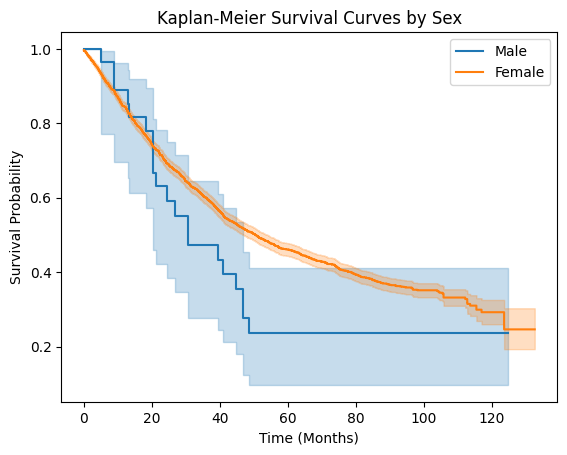

Jumlah Male: 30
Jumlah Female: 3626


In [4]:
# Buat Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Pisahkan data berdasarkan jenis kelamin
male = df[df['Sex'] == 'Male']
female = df[df['Sex'] == 'Female']

# Fit model untuk Male
kmf.fit(male['Overall Survival (Months)'], male['Overall Survival Status'], label='Male')
ax = kmf.plot()

# Fit model untuk Female
kmf.fit(female['Overall Survival (Months)'], female['Overall Survival Status'], label='Female')
kmf.plot(ax=ax)

# Tambahkan label dan judul
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curves by Sex')
plt.legend()
plt.show()

# Print jumlah sampel per kelompok
print(f"Jumlah Male: {len(male)}")
print(f"Jumlah Female: {len(female)}")

# Log-rank test untuk membandingkan survival curves antara Male dan Female
from lifelines.statistics import logrank_test


#### Log Rank Test

In [5]:
results = logrank_test(
    male['Overall Survival (Months)'], 
    female['Overall Survival (Months)'],
    male['Overall Survival Status'], 
    female['Overall Survival Status']
)

print("\n" + "=" * 60)
print("LOG-RANK TEST: Male vs Female")
print("=" * 60)
print(f"Test Statistic: {results.test_statistic:.4f}")
print(f"P-value: {results.p_value:.4f}")
print(f"Degrees of Freedom: {results.degrees_of_freedom}")

if results.p_value < 0.05:
    print("Kesimpulan: Terdapat perbedaan signifikan antara kurva survival Male dan Female (p < 0.05)")
else:
    print("Kesimpulan: Tidak terdapat perbedaan signifikan antara kurva survival Male dan Female (p >= 0.05)")


LOG-RANK TEST: Male vs Female
Test Statistic: 2.7235
P-value: 0.0989
Degrees of Freedom: 1
Kesimpulan: Tidak terdapat perbedaan signifikan antara kurva survival Male dan Female (p >= 0.05)


### Survival Curve by MSI Type

Nilai unik di kolom 'MSI Type':
['Stable' 'Indeterminate' 'Do not report' 'Instable']


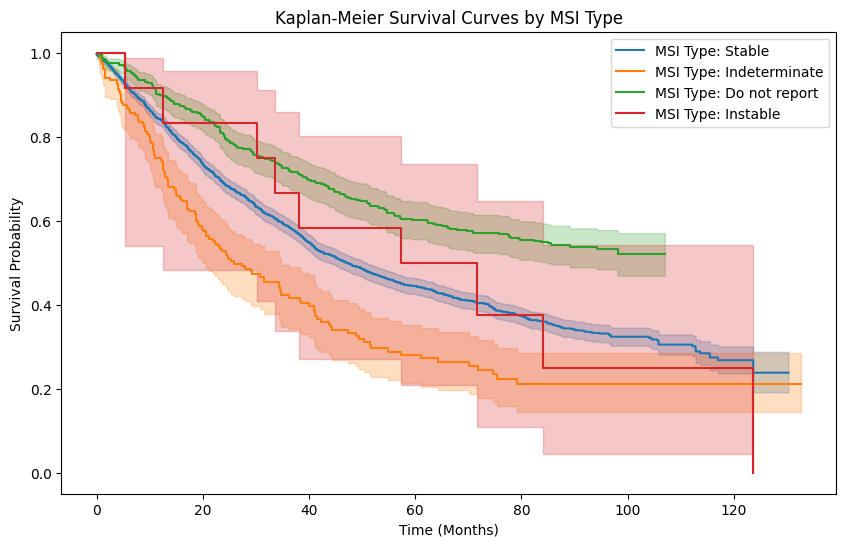


Jumlah sampel per MSI Type:
  Stable: 2926
  Indeterminate: 197
  Do not report: 520
  Instable: 13


In [6]:
# Buat Kaplan-Meier fitter
kmf = KaplanMeierFitter()

# Cek nilai unik MSI Type
print("Nilai unik di kolom 'MSI Type':")
print(df['MSI Type'].unique())

# Pisahkan data berdasarkan MSI Type
msi_groups = df['MSI Type'].unique()

# Buat plot
fig, ax = plt.subplots(figsize=(10, 6))

# Fit dan plot untuk setiap grup MSI Type
for msi_type in msi_groups:
    group_data = df[df['MSI Type'] == msi_type]
    kmf.fit(group_data['Overall Survival (Months)'], 
            group_data['Overall Survival Status'], 
            label=f'MSI Type: {msi_type}')
    kmf.plot(ax=ax)

# Tambahkan label dan judul
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('Kaplan-Meier Survival Curves by MSI Type')
plt.legend()
plt.show()

# Print jumlah sampel per kelompok
print("\nJumlah sampel per MSI Type:")
for msi_type in msi_groups:
    count = len(df[df['MSI Type'] == msi_type])
    print(f"  {msi_type}: {count}")

#### Log Rank Test

In [7]:
# Prepare data untuk multivariate log-rank test
msi_result = multivariate_logrank_test(
    df['Overall Survival (Months)'],
    df['MSI Type'],
    df['Overall Survival Status']
)

print("\n" + "=" * 60)
print("LOG-RANK TEST: Perbandingan antar MSI Type")
print("=" * 60)
print(f"Test Statistic: {msi_result.test_statistic:.4f}")
print(f"P-value: {msi_result.p_value:.4f}")
print(f"Degrees of Freedom: {msi_result.degrees_of_freedom}")

if msi_result.p_value < 0.05:
    print("Kesimpulan: Terdapat perbedaan signifikan antara kurva survival MSI Type (p < 0.05)")
else:
    print("Kesimpulan: Tidak terdapat perbedaan signifikan antara kurva survival MSI Type (p >= 0.05)")


LOG-RANK TEST: Perbandingan antar MSI Type
Test Statistic: 87.5085
P-value: 0.0000
Degrees of Freedom: 3
Kesimpulan: Terdapat perbedaan signifikan antara kurva survival MSI Type (p < 0.05)


#### Pairwise Log Rank Test

In [8]:
# Pairwise log-rank tests untuk melihat perbedaan antar grup
print("\n" + "=" * 60)
print("PAIRWISE LOG-RANK TESTS")
print("=" * 60)

msi_types_list = list(msi_groups)
for i in range(len(msi_types_list)):
    for j in range(i+1, len(msi_types_list)):
        msi1 = msi_types_list[i]
        msi2 = msi_types_list[j]
        
        group1 = df[df['MSI Type'] == msi1]
        group2 = df[df['MSI Type'] == msi2]
        
        result = logrank_test(
            group1['Overall Survival (Months)'],
            group2['Overall Survival (Months)'],
            group1['Overall Survival Status'],
            group2['Overall Survival Status']
        )
        
        print(f"\n{msi1} vs {msi2}:")
        print(f"  Test Statistic: {result.test_statistic:.4f}")
        print(f"  P-value: {result.p_value:.4f}")
        
        if result.p_value < 0.05:
            print(f"  Signifikan (p < 0.05)")
        else:
            print(f"  Tidak signifikan (p >= 0.05)")


PAIRWISE LOG-RANK TESTS

Stable vs Indeterminate:
  Test Statistic: 24.0553
  P-value: 0.0000
  Signifikan (p < 0.05)

Stable vs Do not report:
  Test Statistic: 55.7862
  P-value: 0.0000
  Signifikan (p < 0.05)

Stable vs Instable:
  Test Statistic: 0.0061
  P-value: 0.9376
  Tidak signifikan (p >= 0.05)

Indeterminate vs Do not report:
  Test Statistic: 78.2772
  P-value: 0.0000
  Signifikan (p < 0.05)

Indeterminate vs Instable:
  Test Statistic: 1.3669
  P-value: 0.2423
  Tidak signifikan (p >= 0.05)

Do not report vs Instable:
  Test Statistic: 1.6442
  P-value: 0.1997
  Tidak signifikan (p >= 0.05)


### Overall Survival Curve

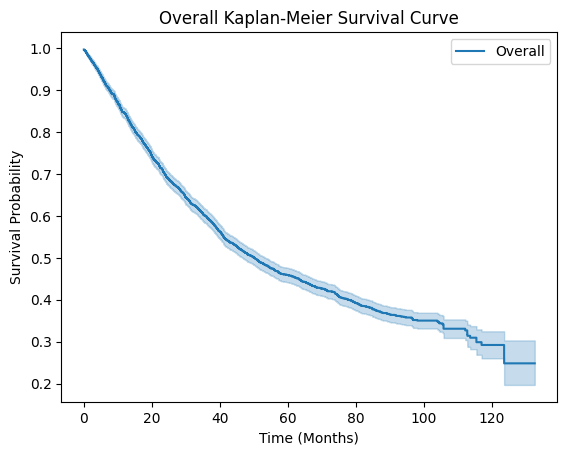

Median Survival Time (Overall): 50.13643686 months


In [9]:
# Overall Kaplan-Meier Survival Curve
kmf_overall = KaplanMeierFitter()
kmf_overall.fit(df['Overall Survival (Months)'], df['Overall Survival Status'], label='Overall')
kmf_overall.plot()
plt.xlabel('Time (Months)')
plt.ylabel('Survival Probability')
plt.title('Overall Kaplan-Meier Survival Curve')
plt.show()

# Median survival time overall
median_overall = kmf_overall.median_survival_time_
print(f"Median Survival Time (Overall): {median_overall} months")

### Median Survival Times

In [10]:
# Median survival times per group
kmf_male = KaplanMeierFitter()
kmf_male.fit(male['Overall Survival (Months)'], male['Overall Survival Status'])

kmf_female = KaplanMeierFitter()
kmf_female.fit(female['Overall Survival (Months)'], female['Overall Survival Status'])

median_male = kmf_male.median_survival_time_
median_female = kmf_female.median_survival_time_

print(f"Median Survival Time (Male): {median_male} months")
print(f"Median Survival Time (Female): {median_female} months")
print(f"Median Survival Time (Overall): {median_overall} months")

Median Survival Time (Male): 30.70651281 months
Median Survival Time (Female): 50.39944768 months
Median Survival Time (Overall): 50.13643686 months


### Survival Probability at Specific Time

In [11]:
# Contoh: Probabilitas survival pada 12 bulan
time_point = 12  # Ganti dengan n bulan yang diinginkan

# Untuk overall
prob_overall = kmf_overall.predict(time_point)
print(f"Survival Probability at {time_point} months (Overall): {prob_overall}")

# Untuk Male
prob_male = kmf_male.predict(time_point)
print(f"Survival Probability at {time_point} months (Male): {prob_male}")

# Untuk Female
prob_female = kmf_female.predict(time_point)
print(f"Survival Probability at {time_point} months (Female): {prob_female}")

Survival Probability at 12 months (Overall): 0.8451867034300574
Survival Probability at 12 months (Male): 0.8901098901098903
Survival Probability at 12 months (Female): 0.844821080945139


### Life Table

In [12]:
### Kaplan-Meier Life Table at Specific Times (Overall)
time_points = [0, 6, 12, 18, 24, 30, 36, 42, 48, 54, 60]

# Buat list untuk tabel
table_data = []
for time in time_points:
    survival_prob = kmf_overall.predict(time)
    at_risk = sum(df['Overall Survival (Months)'] >= time)
    deaths_cumulative = sum((df['Overall Survival (Months)'] <= time) & (df['Overall Survival Status'] == 1))
    table_data.append({
        'Time (Months)': time,
        'At Risk': at_risk,
        'Deaths (Observed, Cumulative)': deaths_cumulative,
        'Survival Probability': survival_prob
    })

# Buat DataFrame
life_table_specific = pd.DataFrame(table_data)

# Tampilkan tabel
print("Kaplan-Meier Life Table at Specific Times (Overall):")
life_table_specific

# save to excel
life_table_specific.to_excel('kaplan_meier_life_table_overall.xlsx', index=False)

Kaplan-Meier Life Table at Specific Times (Overall):


# Cox Regression

## Pemodelan Cox Regression (Full)

In [13]:
# Pilih kolom yang diperlukan
columns_needed = [
    'Overall Survival (Months)',
    'Overall Survival Status',
    'Sex',
    'Primary Tumor Site',
    'MSI Type',
    'Mutation Count',
    'Fraction Genome Altered'
]

# Buat subset data (sudah drop NaN di preprocessing)
data_cox = df[columns_needed]

# Pastikan tipe data benar
data_cox['Overall Survival (Months)'] = data_cox['Overall Survival (Months)'].astype(float)
data_cox['Overall Survival Status'] = data_cox['Overall Survival Status'].astype(int)

# Encode kolom kategorikal ke dummy variables
categorical_cols = ['Primary Tumor Site', 'MSI Type', 'Sex']
data_cox_encoded = pd.get_dummies(data_cox, columns=categorical_cols, drop_first=True)

# Tampilkan info data setelah encoding
print(f"Jumlah sampel setelah encoding: {len(data_cox_encoded)}")
print("Kolom setelah encoding:")
print(data_cox_encoded.columns.tolist())

# Fit model Cox Proportional Hazards
cph = CoxPHFitter(penalizer=0.1)  # Tambahkan penalizer untuk mengatasi kolinearitas
cph.fit(data_cox_encoded, duration_col='Overall Survival (Months)', event_col='Overall Survival Status')

# Tampilkan summary model
print("\nSummary Model Cox:")
print(cph.summary)

C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12948\2442936237.py:16: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cox['Overall Survival (Months)'] = data_cox['Overall Survival (Months)'].astype(float)
C:\Users\LENOVO\AppData\Local\Temp\ipykernel_12948\2442936237.py:17: SettingWithCopyWarning: 
A value is trying to be set on a copy of a slice from a DataFrame.
Try using .loc[row_indexer,col_indexer] = value instead

See the caveats in the documentation: https://pandas.pydata.org/pandas-docs/stable/user_guide/indexing.html#returning-a-view-versus-a-copy
  data_cox['Overall Survival Status'] = data_cox['Overall Survival Status'].astype(int)


Jumlah sampel setelah encoding: 3656
Kolom setelah encoding:
['Overall Survival (Months)', 'Overall Survival Status', 'Mutation Count', 'Fraction Genome Altered', 'Primary Tumor Site_Cancer of unknown primary', 'MSI Type_Indeterminate', 'MSI Type_Instable', 'MSI Type_Stable', 'Sex_Male']

Summary Model Cox:
                                                  coef  exp(coef)  se(coef)  \
covariate                                                                     
Mutation Count                                0.012001   1.012074  0.002169   
Fraction Genome Altered                       1.299710   3.668235  0.109615   
Primary Tumor Site_Cancer of unknown primary  1.197586   3.312112  1.010590   
MSI Type_Indeterminate                        0.405847   1.500572  0.100883   
MSI Type_Instable                             0.117535   1.124721  0.323243   
MSI Type_Stable                               0.369159   1.446518  0.059364   
Sex_Male                                      0.269746   1.

In [14]:
# Lihat nilai unik di kolom kategorikal
print("Nilai unik di 'Primary Tumor Site':")
print(data_cox['Primary Tumor Site'].unique())

print("\nNilai unik di 'MSI Type':")
print(data_cox['MSI Type'].unique())

print("\nNilai unik di 'Sex':")
print(data_cox['Sex'].unique())

Nilai unik di 'Primary Tumor Site':
['Breast' 'Cancer of unknown primary']

Nilai unik di 'MSI Type':
['Stable' 'Indeterminate' 'Do not report' 'Instable']

Nilai unik di 'Sex':
['Female' 'Male']


### Assumption Testing  
Asumsi model awal dengan 7 variabel

In [15]:
# Uji asumsi proportional hazards
print("\nUji Asumsi Proportional Hazards:")
try:
    results = cph.check_assumptions(data_cox_encoded, p_value_threshold=0.05)
    print(results)
except Exception as e:
    print(f"Error dalam uji asumsi: {e}")


Uji Asumsi Proportional Hazards:
Proportional hazard assumption looks okay.
[]


In [16]:
result_all = proportional_hazard_test(cph, data_cox_encoded, time_transform='rank')
print("Proportional Hazard Test for All Data (time_transform='rank'):")
print(result_all)

Proportional Hazard Test for All Data (time_transform='rank'):
<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3656 total observations, 1609 right-censored observations>
         test_name = proportional_hazard_test

---
                                              test_statistic    p  -log2(p)
Fraction Genome Altered                                 0.00 0.99      0.01
MSI Type_Indeterminate                                  1.30 0.25      1.98
MSI Type_Instable                                       1.51 0.22      2.19
MSI Type_Stable                                         0.07 0.79      0.35
Mutation Count                                          0.36 0.55      0.86
Primary Tumor Site_Cancer of unknown primary            0.28 0.60      0.74
Sex_Male                                                0.53 0.47      1.10


In [17]:
# Concordance index
c_index = cph.concordance_index_
print(f"Concordance Index: {c_index}")

Concordance Index: 0.6075789259253961


## Model Cox Regression (Backward)

Dari model Cox di atas, terlihat beberapa variabel tidak signifikan (p-value > 0.05). Kita akan melakukan backward selection untuk mendapatkan model dengan semua variabel yang signifikan.

In [18]:
def backward_selection_cox(data, duration_col, event_col, alpha=0.05):
    """
    Melakukan backward selection untuk model Cox Proportional Hazards
    
    Parameters:
    -----------
    data : DataFrame
        Data yang sudah di-encode
    duration_col : str
        Nama kolom durasi survival
    event_col : str
        Nama kolom event/status
    alpha : float
        Threshold p-value untuk signifikansi (default: 0.05)
    
    Returns:
    --------
    final_model : CoxPHFitter
        Model final hasil backward selection
    """
    
    # Ambil semua kolom prediktor (kecuali duration dan event)
    predictor_cols = [col for col in data.columns if col not in [duration_col, event_col]]
    current_predictors = predictor_cols.copy()
    
    iteration = 0
    print("=" * 80)
    print("BACKWARD SELECTION UNTUK COX PROPORTIONAL HAZARDS MODEL")
    print("=" * 80)
    print(f"\nJumlah variabel awal: {len(current_predictors)}")
    print(f"Alpha (threshold p-value): {alpha}\n")
    
    while True:
        iteration += 1
        print(f"\n{'=' * 80}")
        print(f"ITERASI {iteration}")
        print(f"{'=' * 80}")
        print(f"Jumlah variabel saat ini: {len(current_predictors)}")
        
        # Fit model dengan variabel saat ini
        data_current = data[[duration_col, event_col] + current_predictors].copy()
        
        cph_current = CoxPHFitter(penalizer=0.1)
        cph_current.fit(data_current, duration_col=duration_col, event_col=event_col)
        
        # Dapatkan p-values
        summary = cph_current.summary
        p_values = summary['p']
        
        # Tampilkan ringkasan
        print("\nRingkasan Model Saat Ini:")
        print("-" * 80)
        summary_display = summary[['coef', 'exp(coef)', 'se(coef)', 'z', 'p']].copy()
        summary_display = summary_display.sort_values('p', ascending=False)
        print(summary_display.to_string())
        
        # Cari variabel dengan p-value tertinggi
        max_p_value = p_values.max()
        max_p_var = p_values.idxmax()
        
        print(f"\n{'=' * 80}")
        print(f"Variabel dengan p-value tertinggi: {max_p_var}")
        print(f"P-value: {max_p_value:.6f}")
        
        # Jika semua variabel signifikan, berhenti
        if max_p_value <= alpha:
            print(f"\nSemua variabel signifikan (p-value <= {alpha})")
            print("=" * 80)
            print("\nBACKWARD SELECTION SELESAI!")
            print("=" * 80)
            return cph_current
        
        # Jika masih ada variabel tidak signifikan, hapus yang p-value tertinggi
        print(f"\nMenghapus variabel: {max_p_var} (p-value = {max_p_value:.6f} > {alpha})")
        current_predictors.remove(max_p_var)
        
        # Jika hanya tersisa 1 variabel atau kurang, berhenti
        if len(current_predictors) <= 1:
            print("\nHanya tersisa 1 variabel atau kurang. Menghentikan proses.")
            print("=" * 80)
            return cph_current

# Jalankan backward selection
final_cox_model = backward_selection_cox(
    data_cox_encoded, 
    duration_col='Overall Survival (Months)', 
    event_col='Overall Survival Status',
    alpha=0.05
)

BACKWARD SELECTION UNTUK COX PROPORTIONAL HAZARDS MODEL

Jumlah variabel awal: 7
Alpha (threshold p-value): 0.05


ITERASI 1
Jumlah variabel saat ini: 7

Ringkasan Model Saat Ini:
--------------------------------------------------------------------------------
                                                  coef  exp(coef)  se(coef)          z             p
covariate                                                                                           
MSI Type_Instable                             0.117535   1.124721  0.323243   0.363612  7.161478e-01
Primary Tumor Site_Cancer of unknown primary  1.197586   3.312112  1.010590   1.185037  2.360030e-01
Sex_Male                                      0.269746   1.309632  0.213478   1.263579  2.063811e-01
MSI Type_Indeterminate                        0.405847   1.500572  0.100883   4.022961  5.747098e-05
Mutation Count                                0.012001   1.012074  0.002169   5.534089  3.128502e-08
MSI Type_Stable                 

### Ringkasan Model Final

In [19]:
# Tampilkan summary lengkap model final
print("=" * 80)
print("MODEL FINAL - COX PROPORTIONAL HAZARDS (SETELAH BACKWARD SELECTION)")
print("=" * 80)
print(final_cox_model.summary)

# Informasi tambahan
print("\n" + "=" * 80)
print("INFORMASI MODEL FINAL")
print("=" * 80)
print(f"Jumlah observasi: {final_cox_model.event_observed.shape[0]}")
print(f"Jumlah events: {final_cox_model.event_observed.sum()}")
print(f"Jumlah variabel prediktor: {len(final_cox_model.params_)}")
print(f"\nVariabel dalam model final:")
for i, var in enumerate(final_cox_model.params_.index, 1):
    print(f"  {i}. {var}")

MODEL FINAL - COX PROPORTIONAL HAZARDS (SETELAH BACKWARD SELECTION)
                             coef  exp(coef)  se(coef)  coef lower 95%  \
covariate                                                                
Mutation Count           0.012178   1.012253  0.002125        0.008013   
Fraction Genome Altered  1.300075   3.669573  0.109552        1.085358   
MSI Type_Indeterminate   0.401517   1.494090  0.100538        0.204467   
MSI Type_Stable          0.367581   1.444237  0.058752        0.252428   

                         coef upper 95%  exp(coef) lower 95%  \
covariate                                                      
Mutation Count                 0.016343             1.008046   
Fraction Genome Altered        1.514793             2.960499   
MSI Type_Indeterminate         0.598568             1.226871   
MSI Type_Stable                0.482734             1.287147   

                         exp(coef) upper 95%  cmp to          z             p  \
covariate            

### Interpretasi Model Final

In [20]:
# Interpretasi Hazard Ratio
print("=" * 80)
print("INTERPRETASI HAZARD RATIO (HR)")
print("=" * 80)

summary_final = final_cox_model.summary
for var in summary_final.index:
    coef = summary_final.loc[var, 'coef']
    hr = summary_final.loc[var, 'exp(coef)']
    ci_lower = summary_final.loc[var, 'exp(coef) lower 95%']
    ci_upper = summary_final.loc[var, 'exp(coef) upper 95%']
    p_value = summary_final.loc[var, 'p']
    
    print(f"\n{var}:")
    print(f"  Coefficient: {coef:.4f}")
    print(f"  Hazard Ratio: {hr:.4f}")
    print(f"  95% CI: [{ci_lower:.4f}, {ci_upper:.4f}]")
    print(f"  P-value: {p_value:.4f}")
    
    if hr > 1:
        peningkatan = (hr - 1) * 100
        print(f"  Interpretasi: Meningkatkan risiko kematian sebesar {peningkatan:.2f}%")
    else:
        penurunan = (1 - hr) * 100
        print(f"  Interpretasi: Menurunkan risiko kematian sebesar {penurunan:.2f}%")

INTERPRETASI HAZARD RATIO (HR)

Mutation Count:
  Coefficient: 0.0122
  Hazard Ratio: 1.0123
  95% CI: [1.0080, 1.0165]
  P-value: 0.0000
  Interpretasi: Meningkatkan risiko kematian sebesar 1.23%

Fraction Genome Altered:
  Coefficient: 1.3001
  Hazard Ratio: 3.6696
  95% CI: [2.9605, 4.5485]
  P-value: 0.0000
  Interpretasi: Meningkatkan risiko kematian sebesar 266.96%

MSI Type_Indeterminate:
  Coefficient: 0.4015
  Hazard Ratio: 1.4941
  95% CI: [1.2269, 1.8195]
  P-value: 0.0001
  Interpretasi: Meningkatkan risiko kematian sebesar 49.41%

MSI Type_Stable:
  Coefficient: 0.3676
  Hazard Ratio: 1.4442
  95% CI: [1.2871, 1.6205]
  P-value: 0.0000
  Interpretasi: Meningkatkan risiko kematian sebesar 44.42%


### Perbandingan Model Awal vs Model Final

In [21]:
# Perbandingan metrik model
print("=" * 80)
print("PERBANDINGAN MODEL AWAL VS MODEL FINAL")
print("=" * 80)

# Model awal (semua variabel)
print("\nMODEL AWAL (Semua Variabel):")
print(f"  Jumlah variabel: {len(cph.params_)}")
print(f"  AIC Partial: {cph.AIC_partial_:.4f}")
print(f"  Concordance Index: {cph.concordance_index_:.4f}")
print(f"  Log-likelihood: {cph.log_likelihood_:.4f}")

# Model final (setelah backward selection)
print("\nMODEL FINAL (Setelah Backward Selection):")
print(f"  Jumlah variabel: {len(final_cox_model.params_)}")
print(f"  AIC Partial: {final_cox_model.AIC_partial_:.4f}")
print(f"  Concordance Index: {final_cox_model.concordance_index_:.4f}")
print(f"  Log-likelihood: {final_cox_model.log_likelihood_:.4f}")

# Perbandingan
print("\nPERBANDINGAN:")
print(f"  Selisih AIC Partial: {final_cox_model.AIC_partial_ - cph.AIC_partial_:.4f}")
print(f"    (Nilai negatif = model final lebih baik)")
print(f"  Selisih Concordance: {final_cox_model.concordance_index_ - cph.concordance_index_:.4f}")
print(f"    (Nilai positif = model final lebih baik)")
print(f"  Variabel yang dihapus: {len(cph.params_) - len(final_cox_model.params_)}")

PERBANDINGAN MODEL AWAL VS MODEL FINAL

MODEL AWAL (Semua Variabel):
  Jumlah variabel: 7
  AIC Partial: 31073.0792
  Concordance Index: 0.6076
  Log-likelihood: -15529.5396

MODEL FINAL (Setelah Backward Selection):
  Jumlah variabel: 4
  AIC Partial: 31069.7038
  Concordance Index: 0.6069
  Log-likelihood: -15530.8519

PERBANDINGAN:
  Selisih AIC Partial: -3.3755
    (Nilai negatif = model final lebih baik)
  Selisih Concordance: -0.0006
    (Nilai positif = model final lebih baik)
  Variabel yang dihapus: 3


### Visualisasi Model Final

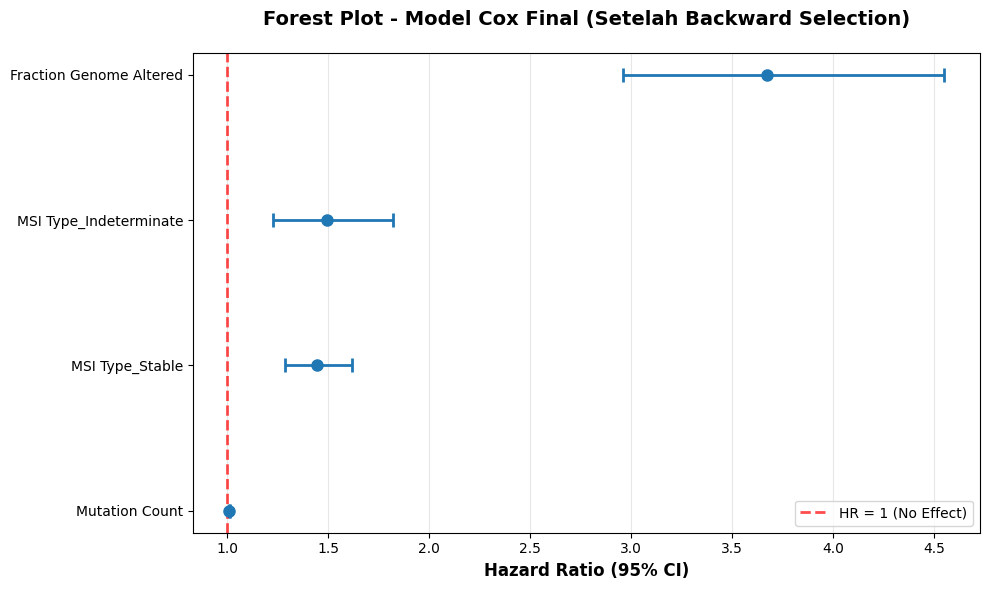


Interpretasi Forest Plot:
- Titik = Hazard Ratio
- Garis horizontal = 95% Confidence Interval
- HR > 1 (kanan garis merah) = Meningkatkan risiko kematian
- HR < 1 (kiri garis merah) = Menurunkan risiko kematian


In [22]:
# Plot hazard ratio dengan confidence interval
fig, ax = plt.subplots(figsize=(10, max(6, len(final_cox_model.params_) * 0.5)))

summary_final = final_cox_model.summary
vars_sorted = summary_final.sort_values('exp(coef)').index

y_pos = np.arange(len(vars_sorted))
hrs = summary_final.loc[vars_sorted, 'exp(coef)']
ci_lower = summary_final.loc[vars_sorted, 'exp(coef) lower 95%']
ci_upper = summary_final.loc[vars_sorted, 'exp(coef) upper 95%']

# Plot points dan error bars
ax.errorbar(hrs, y_pos, xerr=[hrs - ci_lower, ci_upper - hrs], 
            fmt='o', markersize=8, capsize=5, capthick=2, linewidth=2)

# Garis referensi di HR = 1
ax.axvline(x=1, color='red', linestyle='--', linewidth=2, alpha=0.7, label='HR = 1 (No Effect)')

# Format
ax.set_yticks(y_pos)
ax.set_yticklabels(vars_sorted)
ax.set_xlabel('Hazard Ratio (95% CI)', fontsize=12, fontweight='bold')
ax.set_title('Forest Plot - Model Cox Final (Setelah Backward Selection)', 
             fontsize=14, fontweight='bold', pad=20)
ax.grid(axis='x', alpha=0.3)
ax.legend()

plt.tight_layout()
plt.show()

print("\nInterpretasi Forest Plot:")
print("- Titik = Hazard Ratio")
print("- Garis horizontal = 95% Confidence Interval")
print("- HR > 1 (kanan garis merah) = Meningkatkan risiko kematian")
print("- HR < 1 (kiri garis merah) = Menurunkan risiko kematian")

### Uji Asumsi Proportional Hazards - Model Final

Setelah mendapatkan model final, kita perlu menguji apakah asumsi proportional hazards terpenuhi untuk semua variabel dalam model.

In [23]:
# Siapkan data untuk model final (hanya variabel yang tersisa)
final_predictors = list(final_cox_model.params_.index)
data_final = data_cox_encoded[['Overall Survival (Months)', 'Overall Survival Status'] + final_predictors].copy()

print("=" * 80)
print("UJI ASUMSI PROPORTIONAL HAZARDS - MODEL FINAL")
print("=" * 80)
print(f"\nJumlah variabel dalam model final: {len(final_predictors)}")
print("\nVariabel yang diuji:")
for i, var in enumerate(final_predictors, 1):
    print(f"  {i}. {var}")

UJI ASUMSI PROPORTIONAL HAZARDS - MODEL FINAL

Jumlah variabel dalam model final: 4

Variabel yang diuji:
  1. Mutation Count
  2. Fraction Genome Altered
  3. MSI Type_Indeterminate
  4. MSI Type_Stable



CHECK ASSUMPTIONS - MODEL FINAL

   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...


   Bootstrapping lowess lines. May take a moment...

Proportional hazard assumption looks okay.

Hasil Uji Asumsi:
--------------------------------------------------------------------------------

Variabel: Axes(0.0730035,0.155162;0.41329x0.744838)

Terjadi error saat uji asumsi: unsupported format string passed to Axes.__format__

Mencoba metode alternatif...


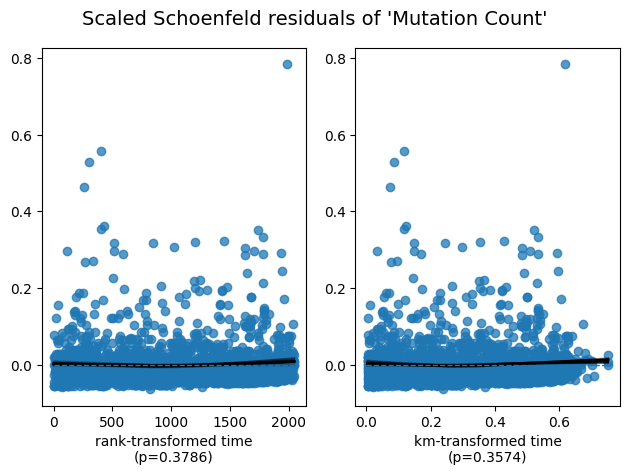

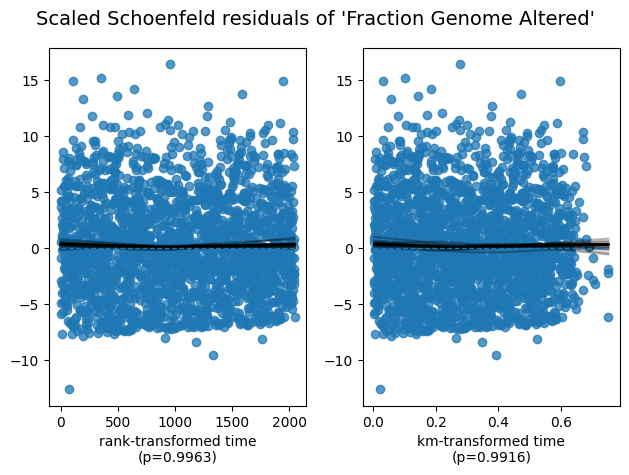

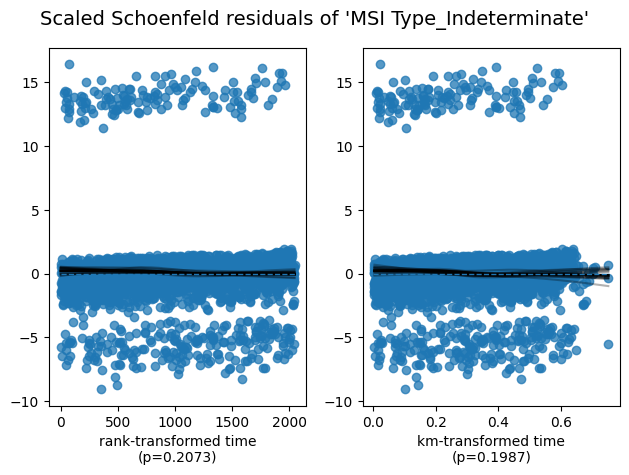

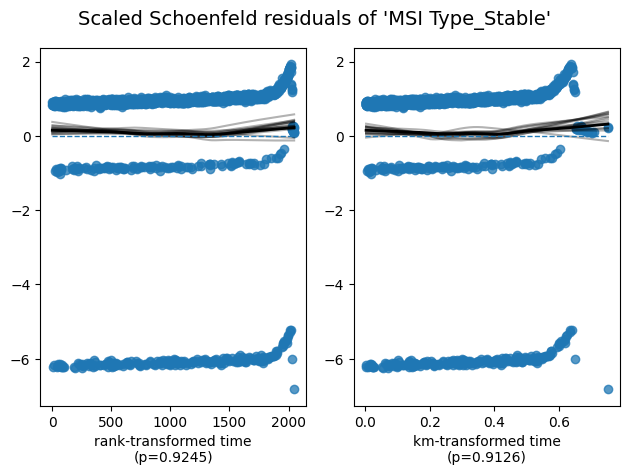

In [24]:
# Check Assumptions menggunakan metode built-in
print("\n" + "=" * 80)
print("CHECK ASSUMPTIONS - MODEL FINAL")
print("=" * 80)

try:
    results_final = final_cox_model.check_assumptions(data_final, p_value_threshold=0.05, show_plots=True)
    
    print("\nHasil Uji Asumsi:")
    print("-" * 80)
    
    # Cek setiap variabel
    for result in results_final:
        print(f"\nVariabel: {result[0]}")
        print(f"  Test statistic: {result[1]:.4f}")
        print(f"  P-value: {result[2]:.4f}")
        if result[2] < 0.05:
            print(f"  Status: TIDAK memenuhi asumsi proportional hazards (p < 0.05)")
        else:
            print(f"  Status: Memenuhi asumsi proportional hazards (p >= 0.05)")
            
except Exception as e:
    print(f"\nTerjadi error saat uji asumsi: {e}")
    print("\nMencoba metode alternatif...")

In [25]:
# Proportional Hazard Test menggunakan time_transform
print("\n" + "=" * 80)
print("PROPORTIONAL HAZARD TEST - MODEL FINAL")
print("=" * 80)

result_final = proportional_hazard_test(final_cox_model, data_final, time_transform='rank')

print("\nHasil Test (time_transform='rank'):")
print(result_final)

print("\n" + "=" * 80)
print("INTERPRETASI HASIL")
print("=" * 80)

# Interpretasi per variabel
test_results = result_final.summary
for idx in test_results.index:
    p_val = test_results.loc[idx, 'p']
    test_stat = test_results.loc[idx, 'test_statistic']
    
    print(f"\n{idx}:")
    print(f"  Test Statistic: {test_stat:.4f}")
    print(f"  P-value: {p_val:.4f}")
    
    if p_val < 0.05:
        print(f"  ❌ TIDAK memenuhi asumsi (p-value < 0.05)")
        print(f"     Variabel ini mungkin melanggar asumsi proportional hazards")
    else:
        print(f"  ✓ Memenuhi asumsi (p-value >= 0.05)")
        print(f"     Asumsi proportional hazards terpenuhi")

# Overall test
print("\n" + "=" * 80)
print("KESIMPULAN OVERALL")
print("=" * 80)

violations = test_results[test_results['p'] < 0.05]
if len(violations) == 0:
    print("\n✓ SEMUA variabel dalam model final memenuhi asumsi proportional hazards!")
    print("  Model dapat digunakan dengan confidence.")
else:
    print(f"\n❌ Terdapat {len(violations)} variabel yang melanggar asumsi:")
    for var in violations.index:
        print(f"  - {var} (p-value = {violations.loc[var, 'p']:.4f})")


PROPORTIONAL HAZARD TEST - MODEL FINAL

Hasil Test (time_transform='rank'):
<lifelines.StatisticalResult: proportional_hazard_test>
    time_transform = rank
 null_distribution = chi squared
degrees_of_freedom = 1
             model = <lifelines.CoxPHFitter: fitted with 3656 total observations, 1609 right-censored observations>
         test_name = proportional_hazard_test

---
                         test_statistic    p  -log2(p)
Fraction Genome Altered            0.00 1.00      0.01
MSI Type_Indeterminate             1.59 0.21      2.27
MSI Type_Stable                    0.01 0.92      0.11
Mutation Count                     0.78 0.38      1.40

INTERPRETASI HASIL

Fraction Genome Altered:
  Test Statistic: 0.0000
  P-value: 0.9963
  ✓ Memenuhi asumsi (p-value >= 0.05)
     Asumsi proportional hazards terpenuhi

MSI Type_Indeterminate:
  Test Statistic: 1.5898
  P-value: 0.2073
  ✓ Memenuhi asumsi (p-value >= 0.05)
     Asumsi proportional hazards terpenuhi

MSI Type_Stable:
  Test

In [26]:
# Concordance Index Model Final
print("\n" + "=" * 80)
print("METRIK PERFORMA MODEL FINAL")
print("=" * 80)

c_index_final = final_cox_model.concordance_index_
print(f"\nConcordance Index: {c_index_final:.4f}")

print("\nInterpretasi Concordance Index:")
if c_index_final >= 0.7:
    print("  ✓ Baik (>= 0.7): Model memiliki kemampuan diskriminasi yang baik")
elif c_index_final >= 0.6:
    print("  ~ Cukup (0.6-0.7): Model memiliki kemampuan diskriminasi yang cukup")
else:
    print("  ❌ Kurang (< 0.6): Model memiliki kemampuan diskriminasi yang lemah")

print(f"\nAIC Partial: {final_cox_model.AIC_partial_:.4f}")
print(f"Log-likelihood: {final_cox_model.log_likelihood_:.4f}")


METRIK PERFORMA MODEL FINAL

Concordance Index: 0.6069

Interpretasi Concordance Index:
  ~ Cukup (0.6-0.7): Model memiliki kemampuan diskriminasi yang cukup

AIC Partial: 31069.7038
Log-likelihood: -15530.8519


## Baseline Hazard $h_0$

In [27]:
# Ekstrak baseline hazard
baseline_hazard = final_cox_model.baseline_hazard_
print("Baseline Hazard Function h0(t):")
print(baseline_hazard)

Baseline Hazard Function h0(t):
            baseline hazard
0.000000           0.003133
0.065753           0.000540
0.098629           0.000540
0.131505           0.000540
0.164382           0.000270
...                     ...
129.302693         0.000000
129.434198         0.000000
130.223230         0.000000
130.288983         0.000000
132.656081         0.000000

[1858 rows x 1 columns]


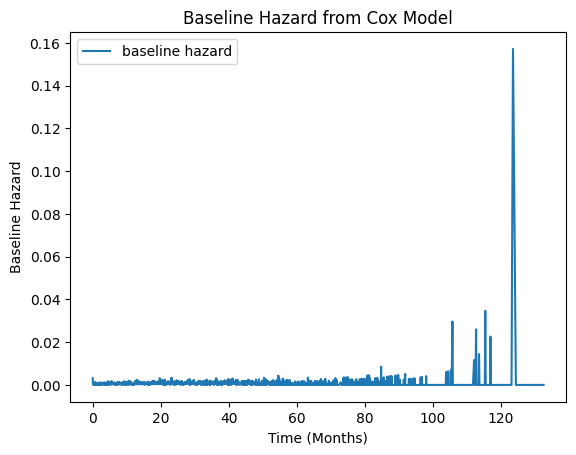

In [28]:
baseline_hazard.plot()
plt.xlabel('Time (Months)')
plt.ylabel('Baseline Hazard')
plt.title('Baseline Hazard from Cox Model')
plt.show()

In [29]:
# simpan baseline hazard ke file excel
baseline_hazard.to_excel('baseline_hazard.xlsx')

## Baseline Cumulative Hazard $H_0$

In [30]:
# Ekstrak baseline hazard cumulative
baseline_cumulative = final_cox_model.baseline_cumulative_hazard_
print("Baseline Hazard Cumulative Function h0(t):")
print(baseline_cumulative)

Baseline Hazard Cumulative Function h0(t):
            baseline cumulative hazard
0.000000                      0.003133
0.065753                      0.003672
0.098629                      0.004212
0.131505                      0.004752
0.164382                      0.005022
...                                ...
129.302693                    1.410590
129.434198                    1.410590
130.223230                    1.410590
130.288983                    1.410590
132.656081                    1.410590

[1858 rows x 1 columns]


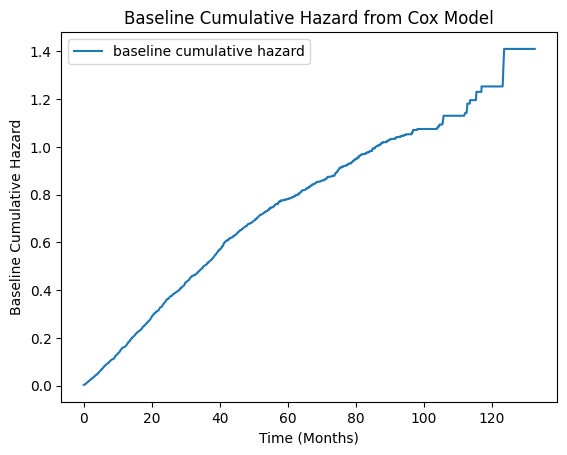

In [31]:
baseline_cumulative.plot()
plt.xlabel('Time (Months)')
plt.ylabel('Baseline Cumulative Hazard')
plt.title('Baseline Cumulative Hazard from Cox Model')
plt.show()

In [32]:
# simpan baseline hazard ke file excel
baseline_cumulative.to_excel('baseline_cumulative_hazard.xlsx')

## Conclusion

Analisis survival breast cancer MSK 2025 telah selesai, termasuk preprocessing data, pemodelan Cox Proportional Hazards, dan perbandingan kurva Kaplan-Meier berdasarkan jenis kelamin. Periksa hasil uji asumsi dan interpretasi model untuk wawasan lebih lanjut.